# Deep Learning
> A catalogue of not so deep ideas in Deep Learning.
- toc: true 
- badges: true
- comments: true
- categories: [Research]


Deep Learning is a collection of techniques for finding functions that can approximate arbitrary input-output mappings, while capturing enough structure of the problem to be able to use them in practical applicatons.language-translation systems,Image classification,Movie Recommendation systems are Some notable applications where they have become defacto-choice. This is by no means an exhaustive treatment of the field. Here I provide concise summaries,followed by a simple implementation of some of the most interesting ideas in the field. I believe that many things in the field are unnecessarily complicated by lengthy treatment where a readable code and short explanation will suffice. 

`Note` : This is not intended to be the first introduction to deep learning. Here I wanted to succintly catalogue some the latest advancements in the field. But, respecting tradition the first module starts from the basics. Only hard prerequisite is to have a good intuition of `matrix multiplication` notion of `taking a derivative`.

## Basics

Many deep learning models follow a simple recipe:

    1. Gather the data.
    2. Define learnable parameters. And specify how they will interact with the data.(architecture)
    3. Define a loss function to minimize.
    4. Adjust the parameters until satisfied.

### Train a linear regression model using gradient-descent.

Here we will see how we can perform all the above steps starting with the most barebones implementation. Note that the procedure outlined here is general purpose - meaning the way we adjust `parameters` is going to remain same irrecpective of the modality of the data, details of the loss function or the architecture.

Step 1. Gather the data

Let's generate some fake data.Let's assume that the data is coming from $y = 2*x1 - 4.2*x2 + 1 + noise(measurement error)$. This can be more succintly represented in vector notation :
$$y = \begin{bmatrix} x1 \\ x2 \end{bmatrix} . \begin{bmatrix} 2 \\ -4.2 \end{bmatrix} + 1$$


    


In [1]:
import numpy as np
def get_data(*params,const=None,rows=1000):
    #number of features in the input
    dim = len(params)
    x = np.random.normal(0,0.3,(rows,dim))
    y = x@np.array([params]).T
    if const:
        y += np.array([const])
    return x,y

x,y = get_data(2,-4.2,const=1)

x.shape,y.shape

((1000, 2), (1000, 1))

Step 2. Define learnable parameters. And specify how they will interact with the data.(architecture)

Now we aim to learn the right coefficients to approximate the data generation process. First let's look at some code.

In [2]:
# Start with a random guess that respects the sanctity of the data.i.e our inputs are of dimension 1000*2 
# outputs are 1000*1. Multiplying inputs by a 2*1 matrix(weights) and adding a constant(bias) is the simplest way
# to ensure an output of 1000*1. 

# initial guess
init_weights = np.array([[0.,-1.]]) #shape -> 1*2
init_bias = np.array([0.])

#expected output
def give_expected_output(inpt,weights,bias):
    return ((inpt@weights.T) + bias)

out = give_expected_output(x,init_weights,init_bias)#shape -> 1000*1

def get_error(out,expected_out):
    return np.mean((expected_out - out)**2)

get_error(out,y) # IF WE CAN DRIVE THIS NUMBER DOWN TO ZERO VIA A GENERAL PURPOSE PROCESS,WE ARE GOOD TO GO

2.121630476687219

In [3]:
def get_grads(weights,bias,x,y,loss_func='squared_loss'):
    if loss_func == 'squared_loss':
        weights_grad = 2*np.mean((x@weights.T + bias - y)*weights)
        bias_grad = 2*np.mean((x@weights.T + bias - y))
    else:
        print("Sorry I'm not yet scalable enough for arbitrary loss functions")
    return weights_grad,bias_grad
        


grad_init_weights,grad_bias = get_grads(init_weights,init_bias,x,y,loss_func = 'squared_loss')

def learn(x,y,init_weights,init_bias,loss_func,lr=0.001,epochs=5000):
    out = give_expected_output(x,init_weights,init_bias)
    error = loss_func(out,y)
    #print(f'initial error, epoch 0: {error}')
    errors = [error]
    pres_lr = lr
    for i in range(epochs):
        weight_grad,bias_grad = get_grads(init_weights,init_bias,x,y)
        init_weights -= weight_grad*pres_lr
        init_bias -= bias_grad*pres_lr
        out = give_expected_output(x,init_weights,init_bias)
        error = loss_func(out,y)
        if np.mean(weight_grad)<0.0001:
            pres_lr = pres_lr*2
        errors.append(error)
    return errors,init_weights,init_bias
        

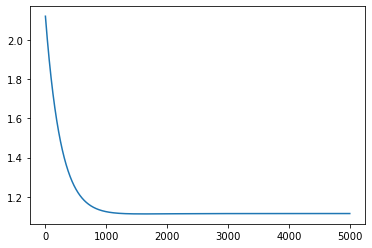

In [4]:
errors,final_weights,final_bias = learn(x,y,init_weights,init_bias,get_error)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(errors)

In [6]:
final_weights,final_bias

(array([[-0.82604061, -1.82604061]]), array([0.97582166]))

In [7]:
# In the above code what happens if 'lr' is not dynamically adjusted.

### Adding Inductive biases - convolutions and recurrent networks.

In the below feedforward network each neuron is connected to all the neurons in the previous layer. No inductive biases in the connectivity.

![FeedForward](my_icons/fc.png "Credit: https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-3/")

`Locality` : For almost all natural signals it is easier to predict the future using recent past compared to any earlier versions. `Locality` allows for the sparsity of weights. We can put faraway weights to zero. In the below figure the `15` weights of the first layer is reduced to `9`. It's also important to be aware of the concept of `receptive field`(RF). `RF` of layer `a` w.r.t `b` is simply the number of neurons in `a` that influence the outputs of layer b.

![](my_icons/sparsity.png "Credit: https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-3/")



`Stationarity` : Same patterns are repeated again and again.
We don't need connections from the inputs far down. `Stationarity` implies weight sharing. 


![](my_icons/parashare.png "Credit: https://atcold.github.io/pytorch-Deep-Learning/en/week03/03-3/")

`Compositionality`: There are hierarchies. Letters make up words,words make up sentences and so on. `Compisitionality` implies deeper networks. 

Now We will see how popular building blocks like CNN'S and RNN'S leverage these properties. `CNN`'s are a linear layer with lots of `weight sharing` and `sparsity`. RNN's just use `weight sharing` but BPTT takes the `locality` into account.

CNN  = linear layer + weight sharing + sparsity.

Consider convolving over a 4 * 4 inputs with a 3 * 3 kernel with a unit stride as presented below.
![](my_icons/cnn.png "Credit:https://arxiv.org/pdf/1603.07285.pdf")

If I stack the 2-d input into a 1-d vector by unrolling left to right and top to bottom, the convolution can be represented as a matrix multiplication.
![](my_icons/conv_mat.png "Credit:https://arxiv.org/pdf/1603.07285.pdf")

The `zeros` along the columns encode `locality` while the replication of same weights along the rows account for `stationarity`. If the above properties doesn't make sense for your input , then CNN's aren't the right choice.

RNN = linear layer + weight sharing + BPTT(Back-prop through time)

![](my_icons/rnn.png "Credit:https://atcold.github.io/pytorch-Deep-Learning/en/week06/06-3/")

RNN's are used for sequence data. In the above figure the `arrow` indicates matrix multiplication. The hidden state `h(t)` at time `t` is equal to Affine_transform(x(t)) + Affine_transform(h(t-1)).(`Note`: Affine_transform refers to matrix multiplication). The following code will makes it all clear.


Consider the following sequence : 

'Hey Jude, don't make it bad.

Take a sad song and make it better.

Remember to let her into your heart,

Then you can start to make it better.
'

Now we would want to classify it into either positive or negative sentiment. Ideally we would have a collection of such sequences with their corresponding labels. Here note that the number of words in each sequence need not be same. A naive approach would be to string all the words in a sequence to a single column,and run it through a fullyconnected network.(variable sequence length still poses a problem.) Let's see how an RNN can accomplish this with much less parameters.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self,i_sz,h_sz,out_sz):
        super().__init__()
        self.i_sz = i_sz
        self.h_sz = h_sz
        self.out_sz = out_sz
        self.input_hidden = nn.Linear(self.i_sz,self.h_sz)
        self.hidden_hidden = nn.Linear(self.h_sz,self.h_sz)
        self.hidden_output = nn.Linear(self.h_sz,self.out_sz)
    def forward(self,x):
        h = 0
        bs,seq_len,emb_sz = x.shape
        for i in range(seq_len):
            # This just adds the hidden representation which is a function of all the words fed until t-1 to the 
            #word at t
            h = h + self.input_hidden(x[:,i,:])
            # Stores the hidden representation for next  word in seq.
            h = F.relu(self.hidden_hidden(h))
        return self.hidden_output(h)
        

In [4]:
bs = 101
seq_len = 10
vector_len = 100
seq_1 = torch.rand(bs,seq_len,vector_len)
rnn = RNN(i_sz = vector_len,h_sz=20,out_sz=1)
out = rnn(seq_1)

out.shape

torch.Size([101, 1])

This can be seen as a two layer network.The last layer converts `h_sz` to the output dimension, while the first layer maps `i_sz` to `h_sz`. But, the first layer only uses weight matrices of size 100 * 20,20 * 20. Totalling of around 2400 parameters. Our naive version would have seq_len * i_sz * h parameters.(around 20000). Moreover, In RNN number of paramenters is independent of
sequence length.

The above model is just an instantiation of `weight sharing` for sequential data. We haven't still leveraged the `locality` aspect (`sparsity`).

Moreover,eventhough we only have 3 different weight matrices,the actual number of layers is proportional to the `size` of the `for loop`. Aside from being very slow and memory intensive, gradients of loss w.r.t initial operations( i = 0) very unlikely to be stable.(According to the chain rule of derivatives the gradient of loss w.r.t first matrix multiplication would involve multiplying atleast `seq_len` of partial derivatives. The resultant can easily explode or vanish.) What if we only take gradients for the last `n` operations. This is also called `Truncated BPTT`. Here's the modified `forward` function.

In [5]:
def forward(self,x):
        h = 0
        bs,seq_len,emb_sz = x.shape
        for i in range(seq_len):
            # This just adds the hidden representation which is a function of all the words fed until t-1 to the 
            #word at t
            h = h + self.input_hidden(x[:,i,:])
            # Stores the hidden representation for next  word in seq.
            h = F.relu(self.hidden_hidden(h))
            if i%3 == 0:
                h = h.detach()
        return self.hidden_output(h)


This just flushes the memory for the backward pass after every 3 steps. Aside from solving obvious practical problems,this also has regularizing effects. We are implicitly encoding our bias - you need not look past the last 3 points in the sequence - a.k.a `locality`.

### Self-Attention

Consider a sequence of vectors ($x_1$,$x_2$..$x_n$). It helps to imagine them as vectors corresponding to sequence of words. If you can bear with me,the following operation converts them into another sequence of vectors ($y_1$,$y_2$..$y_n$) of same dimension.



In [6]:
# Two column vectors(each with dimension of 3*1)
import torch
import torch.tensor as tensor
X = torch.cat([tensor([[1.],[2.],[3.]]),tensor([[4.],[5.],[6.]]),tensor([[7.],[8.],[9.]]),tensor([[10.],[11.],[12.]])],dim=-1)
matrix = torch.rand(4,4) # a random matrix
Y = X@matrix
X.shape,matrix.shape,Y.shape

(torch.Size([3, 4]), torch.Size([4, 4]), torch.Size([3, 4]))

Now,let's generate the same `V` with a fancier set of operations.


In [7]:
temp = X.T@X
Y_new = X@temp.T
Y_new.shape

torch.Size([3, 4])

Here `temp.T` is acting as `matrix`. This also removes the need for additional initialization. This operation also lends to the following intution:

- `temp` is the dot product of each column vector in U with all the vector within it. The captures the measure of similarity between the vectors.
- `Y_new` is just a linear combination of U with the corresponding weights from the `temp`.

- In other words, $y_i =\sum_{j} w_{ij}.x_{j}$ where `w`'s are taken frow the rows of `temp`.


In the above figure each vector $x_{i}$ is used three times. Let's take $x_{2}$ for illustration:

- To get $w_{22}$
- Similarly to get weight's required for all the other outputs $y_1$,$y_3$ and $y_4$ 
- $x_2$ is also used in linear weighting with `w`'s to get $y_2$

But, In the whole compution we are not learning any weights. Everything is being generated from the input. We can introduce three different set of `x`'s for each of the above operations. Let's initialize three square matrices $W_k$,$W_q$,$W_v$, each of size (4,4).

In [8]:
w_k,w_q,w_v = torch.rand(4,4),torch.rand(4,4),torch.rand(4,4) # learnable parameters

keys,queries,values = X@w_k,X@w_q,X@w_v
# This is the naming convention used in the literature.
temp = queries.T@keys
Y_new =values@temp.T
Y_new.shape

torch.Size([3, 4])

That's it. `Self-attention` refers to performing above operations. We additionally normalize the weights in the `temp` with `softmax`. Further, We can also use sets of matrices ($W_k$,$W_q$,$W_v$),essentially replicationg self-attention with different weight matrices. The resulting outputs can be concatenated and be passed through a linear layer to get back the orginal dimension.(This is called `multi-head attention`)

In [9]:
import torch.nn as nn
import math
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self,feat_sz,n_heads=1):
        super().__init__()
        # for n_heads we need the corresponding number of weight matrices of size feat_sz*feat_sz to get new
        #set of (keys,queries,values),Computationally this can be fused inside a single linear operation.
        self.heads = n_heads
        self.get_keys = nn.Linear(feat_sz,feat_sz*n_heads,bias=False)
        self.get_queries = nn.Linear(feat_sz,feat_sz*n_heads,bias=False)
        self.get_values = nn.Linear(feat_sz,feat_sz*n_heads,bias=False)
        self.comb_heads = nn.Linear(n_heads*feat_sz,feat_sz)
        
    def forward(self,x):
        # typically data is fed with features along the `columns`.
        bs,n_seq,feat_sz = x.size()
        keys = self.get_keys(x).view(bs,n_seq,self.heads,feat_sz)
        queries = self.get_queries(x).view(bs,n_seq,self.heads,feat_sz)
        values = self.get_values(x).view(bs,n_seq,self.heads,feat_sz)
        # `torch.bmm` performs matrix multiplication for a given batch.It is efficient to squeeze n_heads along
        # with batches and perform the calculation at once.
        keys = keys.transpose(1,2).contiguous().view(bs*self.heads,n_seq,feat_sz)
        queries = queries.transpose(1,2).contiguous().view(bs*self.heads,n_seq,feat_sz)
        values = values.transpose(1,2).contiguous().view(bs*self.heads,n_seq,feat_sz)
        dot = torch.bmm(queries,keys.transpose(1,2))
        #Rescaling the elements to control the scale
        dot = dot/math.sqrt(feat_sz)
        dot = F.softmax(dot,dim=2)
        out = torch.bmm(dot,values).view(bs,self.heads,n_seq,feat_sz)
        #reshaping
        out = out.transpose(1,2).contiguous().view(bs,n_seq,self.heads*feat_sz)
        # passing through a linear layer to combine all the heads
        out = self.comb_heads(out)# gives bs,n_seq,n_heads
        
        return out

In [10]:
input_ = X.unsqueeze(0).transpose(1,2) # input with features arranged in columns(shape = [1, 4, 3])

sa = SelfAttention(feat_sz=3)
Y = sa(input_)# simple attention

mha = SelfAttention(feat_sz=3,n_heads=6)
Y_6 = sa(input_)

Y.shape,Y_6.shape

(torch.Size([1, 4, 3]), torch.Size([1, 4, 3]))

> Note: Attention is first introduced to deal with sequences in the context of natural language. But, nothing in the above implementation handles `order`. It just maps a `set of vectors` to another. To enforce order, we can simply add a `position vector` to our inputs.

Above ideas mark the end of the theoretical minimum needed. Below you would find the notched up version of the above content by solving simple but practical problems end-end.

## Deep RL Methods

### Motivation

Deep Learning allows for learning generalizable mappings between input and output. In supervised setting we are given a `fixed dataset` D = {$(x_{i},y_{i})$},and are tasked to predict $y_{i}$ using $x_{i}$. Thus, we know groud truth for all the input data. This let's us formulate a `loss` that reflects our dissatisfaction with the predicted `outputs` and optimize over it. But, consider how we learn to perform any new task ? The dataset and the learning signal comes sequentially and is also dependent on our actions. We don't have prepared datasets in real life. We learn from experience. `RL` deals with learning under this natural setting. The key difference to note is that the dataset is not `constant`, It changes everytime, contingent on your actions and the stochasticity in the environment. To make this clear, consider learning to play a video game. The pixels (call it `state`) and the score you receive ( call it `reward`) cannot be predetermined until you actually go through the experience. Here the dataset D = {$(state_{i},reward_{i})$} is not same everytime you play the game. `RL` provides a formalism for learning optimal decision making. This will become clear when we see some concrete examples and code. But combing these techniques with `Neural networks` has given us general algorithms that `learn to play atari games`, `beat world champions at Go` and `train robots to learn simple tasks`.
![](my_icons/rlsuc.png "Credit: http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-1.pdf")

### Problem

Consider the Following optimization problem. Find the shortest path from state $s_0$ to goal $g$,where the edges indicate the cost/distance ?

![](my_icons/sp.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")

Here taking a greedy approach will fail as actions will have long-term consequences. Solving the above problem efficiently requires realizing that `the distance to any node along the shortest path from source to destination is also shortest path`. In the above example the shortest path to `g` should either be through `d` or `f`.(one of the incoming edges). Let the shortest distance from a node `s` to `g` be given by $v^{*}(s)$. Then the last edge of the shortest path should come from evaluating $v^{*}(f))$ and $v^{*}(d)$, where $v^{*}(f) = 1 + v^{*}(g)$ and $v^{*}(d) = min(3+v^{*}(g),1+v^{*}(f))$. This backtracking or dynamic programming approach of finding one edge at a time is illustrated below.


![](my_icons/op.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")


Now, for each action we take, let us also add a `transition probability` that defines the likelihood of ending up in any of the available states given the action. Here, for states `c` and `e` we added some randomness. This will let us model more realistic scenarios. Consider an `RL agent` driving your car. The consequences of any action (eg: Turning the steering to the right given the visual view of the road.) can only be modeled probabilistically.

![](my_icons/ssp.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")


Here by weighting w.r.t the transition probabilities we can recover $v^{*}()$ for all states. Optimal policy is again achieved by acting greedily w.r.t $v^{*}()$. For example , $v^{*}(c) = min(4+0.3*v^{*}(e)+0.7*v^{*}(d),2+v^{*}(e))$. In RL, we call this `Bellmann Equation`.

![](my_icons/sspb.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")

![](my_icons/be.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")


Modern `Deep RL` deals with solving this stochastic version of the problem when the transition probabilities are not available and the number of possible states is very large. Consider the following video game playing scenario. The pixels on the screen at any timestamp can be taken as `state`. The game rules provides list of `possible actions` and the corresponding `reward`(increase in score).

![](my_icons/vid.png "Credit: https://nanjiang.cs.illinois.edu/files/cs598/slides_intro_f20.pdf")

By the end of this module we will develop all the machinery to understand the algorithms that learn optimal(or good) policies for this general case.

### Bellmann Equation and MDP's

In this section we will devolop some theory. First let's define an object called Markov Decision Process (MDP),given by the tuple of $(S,A,P,R,\gamma)$. Here discounting factor $\gamma$ is largely a mathematical convenience as it helps to bound the `total reward`. Any reward $r_t$ received at timestamp `t` is multiplied by $\gamma^{t-1}$, that is we prefer immediate rewards over faraway ones. The term `Markov` refers to the fact that given present state `s` and action taken from there `a`, next state is independent of the past trajectory. Consider the example of `stochastic shortest path` but with the goal state `g` infinitely far away. In that setting we want to maximize the average reward we will get starting from any state.


The only `knob` agent has is policy $\pi : S \rightarrow A$.(which of the possible actions to take). The environment dynamics (P and R) are not under agent's control. For simplicity,let's assume that rewards are bounded and positive. Let's say that the agent has a policy $\pi$ and starts to intreract with the environment. The value function `v(s)` refers to the average reward starting from state `s` and following policy $\pi$. Then `v(s)` for all the states satisfies a recursive definition as shown below.

![](my_icons/bellmann.png "")


Thus finding $v^{\pi}(s)$ amounts to solving system of linear equation or in matrix notation finding the inverse of a matrix. But, we still need the proof for the existence of the inverse for $I - \gamma.P^{\pi}$. Before going further, it's important to thoroughly understand the bellmann equation : $V^{\pi} = R^{\pi} + \gamma.P^{\pi}.V^{\pi}$. The deriviation involves observing the fact that once the agent takes initial action from state `s`, the transition probability will dictate it's next state `s'`. From there, the average reward by definition is  given by `v(s')`, leaving a recursive definition.


![](my_icons/matform.png "")

Below i have give the proof for the existence of inverse. If we recall, a matrix A($n * n$) multiplied by a column vector X ($n * 1$) merely takes a linear combination of all the column vectors in A. Existence of inverse to `A` means that there doesnot exist a non-zero vector X, that can collapse A to a null vector. Using this fact and the traingular inequality on $I - \gamma.P^{\pi}$ completes the proof.



![](my_icons/proof.jpg "")


Now let's define $v^{*}(s)$ as the maximum expected reward that we can get from state `s` under `any policy`. Once we are able to extract these values, optimal policy becomes obvious. `Value Iteration` methods try to apprimate this $V^{*}(s)$. They start with some arbitrary function like $f(s) = 0 \forall s$ and iteratively bring $f$ closer to $V^{*}$. Let's also define $Q^{\pi}(s,a)$ as the expected reward under the policy $\pi$,when we take action `a` at state `s` and sebsequently sample actions according to $\pi$. Similarly $Q^{*}(s,a)$ is also defined as the maximum Q that can be achieved under any policy. We often want $Q^{*}$ values over $V^{*}$ as simply choosing greedily w.r.t $Q^{*}$ gives the optimal policy. To see the advantage more clearly, Imagine an oracle that can give you $V^{*}$ for any `s`. Now, the agent starts at state `s` and is looking to take optimal action. It first has to take all possible actions from that state to see where it would end up. And for each subsequent state `s'` , it has to query the oracle to get $V^{*}(s')$. Only after this we can determine the best action from initial state s as $max_{a\in A}(r_1 + v^{*}(s'))$. But having $Q^{*}$ values let's us choose this action  directly by evaluating $Q_{a\in A}^{*}(s,a)$. There exists a proof that for discounted infinite horizon MDP's there exists a stationary and deterministic optimal policy for all states simultaneously. Let's call this $\pi^{*}$. It is easy to see that both $V^{*}$ and $Q^{*}$ will also satisfy a similar recursive relation called `Bellmann Optimality equations`.


![](my_icons/b.jpg "")


We can also define bellmann operator that let's us concisely reprent the equations. Next.


![](my_icons/b2.jpg "")

![](my_icons/vi1.jpg "")

![](my_icons/vi2.jpg "")

![](my_icons/vi3.jpg "")